# Standard SWEI and Heldmyer et. al. Drought classification comparison workflow

In [1]:
# Install the snowdroughtindex package
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.integrate import trapz
from scipy.stats import norm

# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation, gap_filling, sswei
from snowdroughtindex.utils import visualization

# 1. Data Loading

In [54]:
data_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\casr_data\bow_combined_data.csv'
output_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\modelled_data_snowdrought\\'
shapefile_path = r'C:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\input_data\Elevation\Bow_elevation_combined.shp'

In [56]:
# Load data data
CaSR_data = pd.read_csv(data_path)

# Load shapefile for Bow Basin
bow_basin = gpd.read_file(shapefile_path)

# CaSR dataframe
bow_data = CaSR_data[['time', 'Grid_id','lon', 'lat', 'SWE', 'Precipitation', 'Elevation_Category']].copy()
bow_data['time'] = pd.to_datetime(bow_data['time'])

display(bow_data.head())



,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category
0,1980-10-10,1,-116.13797,51.334590,0.878418,0.009879,2000_2500m
1,1982-07-19,1,-116.13797,51.334590,0.515625,2.765854,2000_2500m
2,1983-10-12,2,-116.18750,51.419113,6.875000,0.023846,2000_2500m
3,1980-12-11,2,-116.18750,51.419113,118.125000,4.578907,2000_2500m
4,1981-07-21,2,-116.18750,51.419113,0.000000,5.400473,2000_2500m


# 2. Calculation of climatological mean SWE

In [57]:
# Pivot the table to get mean SWE time series for each elevation category
mean_SWE_by_elev = bow_data.pivot_table(index='time', columns='Elevation_Category', values='SWE', aggfunc='mean')

display(mean_SWE_by_elev)


Elevation_Category,1000_1500m,1500_2000m,2000_2500m,500_1000m
time,,,,
1980-01-01,9.556588,18.021978,82.479169,23.090965
1980-01-02,12.647925,19.409835,83.036111,25.260611
1980-01-03,11.768311,18.534366,81.822222,27.069211
1980-01-04,10.383333,17.111607,81.172222,27.899554
1980-01-05,9.335417,16.311607,80.055556,28.098772
...,...,...,...,...
2023-12-27,4.994759,19.681349,59.825000,1.650675
2023-12-28,4.306356,18.674477,59.371902,1.517384
2023-12-29,3.917008,18.753924,60.202105,1.410878


In [58]:
# Reset the index to make 'time' a regular column
SWE_data_reset = mean_SWE_by_elev.reset_index()

# Convert 'time' column to datetime
SWE_data_reset['time'] = pd.to_datetime(SWE_data_reset['time'])

# Get peak SWE for each elevation category for each year 1981-2010
peak_SWE_by_elev = SWE_data_reset[SWE_data_reset['time'].dt.year.isin(range(1981, 2011))].groupby(
    SWE_data_reset['time'].dt.year)[['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']].max().reset_index()

# Rename the columns for clarity
peak_SWE_by_elev = peak_SWE_by_elev.rename(columns={'time': 'Year'})
peak_SWE_by_elev = peak_SWE_by_elev.rename(columns={col: f'peak_{col}' for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']})

# Display the result
display(peak_SWE_by_elev)

# Save the peak SWE by elevation data
peak_SWE_by_elev.to_csv(output_path + 'peak_SWE_by_elev.csv', index=False)


Elevation_Category,Year,peak_1000_1500m,peak_1500_2000m,peak_2000_2500m,peak_500_1000m
0,1981,24.797070,44.364788,154.827127,28.219308
1,1982,26.354167,44.508929,161.058333,40.208705
2,1983,30.337500,38.036621,161.275000,46.500000
3,1984,28.929175,33.191089,130.524913,34.360491
4,1985,17.887549,36.879576,142.178972,55.231249
5,1986,28.067936,52.775286,220.311111,132.013611
6,1987,24.028027,44.116602,132.038889,76.542821
7,1988,23.063322,41.261482,138.454850,49.833705
8,1989,35.166667,53.646429,172.175000,60.639509
9,1990,25.283854,54.767857,210.295399,68.024567


In [59]:
# 5% of the average peak SWE
# Calculate 5% of the average peak SWE for each elevation category separately
min_SWE_by_category = 0.05 * peak_SWE_by_elev[['peak_1000_1500m', 'peak_1500_2000m', 'peak_2000_2500m', 'peak_500_1000m']].mean()
print(min_SWE_by_category)

Elevation_Category
peak_1000_1500m    1.584179
peak_1500_2000m    2.124508
peak_2000_2500m    7.334886
peak_500_1000m     2.119068
dtype: float64


In [60]:
# Ensure 'time' column is in datetime format
bow_data['time'] = pd.to_datetime(bow_data['time'])
bow_data['Precipitation'] = CaSR_data['Precipitation']

# Define water year for each coordinate_id time series
water_year_grid = bow_data[(bow_data['time'].dt.month >= 10) | (bow_data['time'].dt.month <= 9)]
water_year_grid['Season_year'] = water_year_grid['time'].dt.year
water_year_grid['Season_year'] = water_year_grid['Season_year'].where(water_year_grid['time'].dt.month >= 10, water_year_grid['Season_year'] - 1)

# drop 1979
water_year_grid = water_year_grid[water_year_grid['Season_year'] >= 1980]
#drop 2017
water_year_grid = water_year_grid[water_year_grid['Season_year'] < 2023]
# Display the updated dataframe
display(water_year_grid)

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year
0,1980-10-10,1,-116.13797,51.334590,0.878418,0.009879,2000_2500m,1980
1,1982-07-19,1,-116.13797,51.334590,0.515625,2.765854,2000_2500m,1981
2,1983-10-12,2,-116.18750,51.419113,6.875000,0.023846,2000_2500m,1983
3,1980-12-11,2,-116.18750,51.419113,118.125000,4.578907,2000_2500m,1980
4,1981-07-21,2,-116.18750,51.419113,0.000000,5.400473,2000_2500m,1980
...,...,...,...,...,...,...,...,...
4130242,2021-06-25,253,-111.75397,50.070770,0.000000,3.667285,500_1000m,2020
4130243,2020-04-17,253,-111.75397,50.070770,0.902344,0.001052,500_1000m,2019
4130244,2023-04-03,253,-111.75397,50.070770,3.375000,6.179713,500_1000m,2022
4130245,2021-12-15,253,-111.75397,50.070770,1.625000,0.002916,500_1000m,2021


In [61]:
# Save the combined data to a CSV file
bow_data.to_csv(output_path + 'bow_combined_data.csv', index=False)

In [63]:
# Calculate daily SWE change considering each coordinate_id
water_year_grid['daily_SWE_change'] = water_year_grid.groupby(['Grid_id', 'Season_year'])['SWE'].diff().shift(-1)
water_year_grid['daily_SWE_change'] = water_year_grid['daily_SWE_change'].fillna(0)
water_year_grid.loc[water_year_grid['daily_SWE_change'] < 0, 'daily_SWE_change'] = 0

# Display the updated DataFrame
display(water_year_grid)

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change
0,1980-10-10,1,-116.13797,51.334590,0.878418,0.009879,2000_2500m,1980,0.000
1,1982-07-19,1,-116.13797,51.334590,0.515625,2.765854,2000_2500m,1981,0.000
2,1983-10-12,2,-116.18750,51.419113,6.875000,0.023846,2000_2500m,1983,0.000
3,1980-12-11,2,-116.18750,51.419113,118.125000,4.578907,2000_2500m,1980,0.000
4,1981-07-21,2,-116.18750,51.419113,0.000000,5.400473,2000_2500m,1980,0.000
...,...,...,...,...,...,...,...,...,...
4130242,2021-06-25,253,-111.75397,50.070770,0.000000,3.667285,500_1000m,2020,0.000
4130243,2020-04-17,253,-111.75397,50.070770,0.902344,0.001052,500_1000m,2019,3.375
4130244,2023-04-03,253,-111.75397,50.070770,3.375000,6.179713,500_1000m,2022,1.250
4130245,2021-12-15,253,-111.75397,50.070770,1.625000,0.002916,500_1000m,2021,0.000


In [66]:
# Initialize an empty DataFrame to store the results
onset_to_peak = pd.DataFrame()

# Iterate through each coordinate_id
for coordinate_id in water_year_grid['Grid_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = water_year_grid[water_year_grid['Grid_id'] == coordinate_id]
    
    # Iterate through each season year for the current coordinate_id
    for year in coord_data['Season_year'].unique():
        # Filter the data for the current season year
        season_data = coord_data[coord_data['Season_year'] == year]
        
        # Get the elevation category for this group
        elev_cat = season_data['Elevation_Category'].iloc[0]
        # Get the correct threshold for this elevation category
        threshold = min_SWE_by_category[f'peak_{elev_cat}']
        # Find the onset date
        onset_date = season_data[season_data['SWE'] >= threshold]['time'].min()
        
        # Find the peak date
        peak_date = season_data[season_data['SWE'] == season_data['SWE'].max()]['time'].values[0]
        
        # Select data from onset to peak
        selected_data = season_data[(season_data['time'] >= onset_date) & (season_data['time'] <= peak_date)]
        
        # Append the selected data to the result DataFrame
        onset_to_peak = pd.concat([onset_to_peak, selected_data])

# Display the result
display(onset_to_peak)

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change
2992,1981-02-11,1,-116.13797,51.33459,152.250000,0.000000,2000_2500m,1980,0.570312
31557,1980-11-07,1,-116.13797,51.33459,27.000000,2.128011,2000_2500m,1980,0.000000
31560,1980-12-21,1,-116.13797,51.33459,110.625000,3.271602,2000_2500m,1980,0.000000
31583,1980-10-25,1,-116.13797,51.33459,12.625000,0.000000,2000_2500m,1980,27.875000
31584,1980-11-13,1,-116.13797,51.33459,40.500000,0.007695,2000_2500m,1980,13.000000
...,...,...,...,...,...,...,...,...,...
4127056,2022-11-08,257,-111.62024,50.09605,23.125000,5.015135,500_1000m,2022,0.000000
4127296,2022-11-04,257,-111.62024,50.09605,8.500000,0.026440,500_1000m,2022,0.520508
4127353,2022-10-24,257,-111.62024,50.09605,0.625000,4.340502,500_1000m,2022,0.000000
4127413,2022-10-30,257,-111.62024,50.09605,0.000061,0.001129,500_1000m,2022,0.000000


# Standardized SWEI

1. Perturb zeros

In [67]:
onset_to_peak['pertub_SWE'] = sswei.perturb_zeros(onset_to_peak['daily_SWE_change'])

display(onset_to_peak)

,time,Grid_id,lon,lat,SWE,Precipitation,Elevation_Category,Season_year,daily_SWE_change,pertub_SWE
2992,1981-02-11,1,-116.13797,51.33459,152.250000,0.000000,2000_2500m,1980,0.570312,0.570312
31557,1980-11-07,1,-116.13797,51.33459,27.000000,2.128011,2000_2500m,1980,0.000000,0.000002
31560,1980-12-21,1,-116.13797,51.33459,110.625000,3.271602,2000_2500m,1980,0.000000,0.000010
31583,1980-10-25,1,-116.13797,51.33459,12.625000,0.000000,2000_2500m,1980,27.875000,27.875000
31584,1980-11-13,1,-116.13797,51.33459,40.500000,0.007695,2000_2500m,1980,13.000000,13.000000
...,...,...,...,...,...,...,...,...,...,...
4127056,2022-11-08,257,-111.62024,50.09605,23.125000,5.015135,500_1000m,2022,0.000000,0.000011
4127296,2022-11-04,257,-111.62024,50.09605,8.500000,0.026440,500_1000m,2022,0.520508,0.520508
4127353,2022-10-24,257,-111.62024,50.09605,0.625000,4.340502,500_1000m,2022,0.000000,0.000008
4127413,2022-10-30,257,-111.62024,50.09605,0.000061,0.001129,500_1000m,2022,0.000000,0.000013


2. SWE intergration

In [73]:
def integrate_season(group: pd.DataFrame) -> pd.Series:
    """
    Integrate SWE values over a season for each coordinate_id.
    
    Parameters
    ----------
    group : pandas.DataFrame
        DataFrame containing SWE values for a specific coordinate_id and season.
        
    Returns
    -------
    pandas.Series
        Series containing the integrated SWE value for the season.
    """
    # Ensure dates are sorted
    group = group.sort_values(by='time')
    
    # Convert dates to numerical days since the start of the season
    days_since_start = (group['time'] - group['time'].min()).dt.days
    
    # Integrate SWE over the season
    total_swe_integration = trapz(group['SWE'], days_since_start)
    
    return pd.Series({'Grid_id': group['Grid_id'].iloc[0],
                      'Season_year': group['Season_year'].iloc[0],
                      'Elevation_Category': group['Elevation_Category'].iloc[0],
                      'total_SWE_integration': total_swe_integration})

# Apply the integration function to each group of coordinate_id and season_year
SWE_integration = onset_to_peak.groupby(['Grid_id', 'Season_year', 'Elevation_Category']).apply(integrate_season).reset_index(drop=True)

display(SWE_integration)

,Grid_id,Season_year,Elevation_Category,total_SWE_integration
0,1,1980,2000_2500m,27721.888180
1,1,1981,2000_2500m,29420.375244
2,1,1982,2000_2500m,23654.764770
3,1,1983,2000_2500m,18605.812500
4,1,1984,2000_2500m,22005.529297
...,...,...,...,...
11046,257,2018,500_1000m,710.818237
11047,257,2019,500_1000m,0.000000
11048,257,2020,500_1000m,53.292969
11049,257,2021,500_1000m,102.590820


3. Gringorten plotting position

In [80]:
# Apply gringorten_probabilities grouped by coordinate_id
SWE_integration['gringorten_probability'] = SWE_integration.groupby('Grid_id')['total_SWE_integration'].transform(sswei.gringorten_probabilities)

# Display the updated DataFrame
display(SWE_integration)

,Grid_id,Season_year,Elevation_Category,total_SWE_integration,gringorten_probability
0,1,1980,2000_2500m,27721.888180,0.755102
1,1,1981,2000_2500m,29420.375244,0.871058
2,1,1982,2000_2500m,23654.764770,0.592764
3,1,1983,2000_2500m,18605.812500,0.384045
4,1,1984,2000_2500m,22005.529297,0.546382
...,...,...,...,...,...
11046,257,2018,500_1000m,710.818237,0.731911
11047,257,2019,500_1000m,0.000000,0.012987
11048,257,2020,500_1000m,53.292969,0.059369
11049,257,2021,500_1000m,102.590820,0.128942


4. Compute Standardized SWEI

In [81]:
# Compute SSWEI grouped by coordinate_id
SWE_integration['SSWEI'] = SWE_integration.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(SWE_integration)

,Grid_id,Season_year,Elevation_Category,total_SWE_integration,gringorten_probability,SSWEI
0,1,1980,2000_2500m,27721.888180,0.755102,0.690633
1,1,1981,2000_2500m,29420.375244,0.871058,1.131404
2,1,1982,2000_2500m,23654.764770,0.592764,0.234662
3,1,1983,2000_2500m,18605.812500,0.384045,-0.294875
4,1,1984,2000_2500m,22005.529297,0.546382,0.116526
...,...,...,...,...,...,...
11046,257,2018,500_1000m,710.818237,0.731911,0.618603
11047,257,2019,500_1000m,0.000000,0.012987,-2.226600
11048,257,2020,500_1000m,53.292969,0.059369,-1.560091
11049,257,2021,500_1000m,102.590820,0.128942,-1.131404


In [83]:
# Group by season_year and calculate the mean SSWEI for each year
# Group by Season_year and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI_per_year = SWE_integration.groupby(['Season_year', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI_per_year = average_SSWEI_per_year.pivot(index='Season_year', columns='Elevation_Category', values='SSWEI').reset_index()

# No need to rename columns here, as the pivot already gives correct column names

# Display the result
display(average_SSWEI_per_year)

Elevation_Category,Season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m
0,1980,-0.941363,-0.624877,0.313973,-0.851694
1,1981,0.307584,0.265648,0.308140,0.704126
2,1982,-0.215287,0.147100,0.087284,0.654919
3,1983,-0.557649,-0.404771,-0.127808,0.386459
4,1984,-0.283910,0.523561,0.240006,1.071492
5,1985,0.772483,0.952029,1.256569,1.401716
6,1986,0.121657,0.129298,-0.225856,0.802827
7,1987,-0.312637,-0.005976,-0.623339,0.300021
8,1988,0.512149,0.655861,0.512816,1.265374
9,1989,0.716595,1.021759,1.536623,0.865879


5. Classification

In [85]:
# Apply the classify_drought function to each value in the average_SSWEI column
# Apply the classify_drought function to each elevation column
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    average_SSWEI_per_year[f'Classification_{col}'] = average_SSWEI_per_year[col].apply(sswei.classify_drought)

# Do not rename columns here, as the DataFrame now has more columns after classification
# If you want to keep only certain columns, select them explicitly, e.g.:
# average_SSWEI_per_year = average_SSWEI_per_year[['Season_year', '1000_1500m', 'Classification_1000_1500m', ...]]

#remove decimal points from season year
average_SSWEI_per_year['Season_year'] = average_SSWEI_per_year['Season_year'].astype(int)

# Display the updated DataFrame
display(average_SSWEI_per_year)

Elevation_Category,Season_year,1000_1500m,1500_2000m,2000_2500m,500_1000m,Classification_1000_1500m,Classification_1500_2000m,Classification_2000_2500m,Classification_500_1000m
0,1980,-0.941363,-0.624877,0.313973,-0.851694,Moderate Drought,Moderate Drought,Near Normal,Moderate Drought
1,1981,0.307584,0.265648,0.308140,0.704126,Near Normal,Near Normal,Near Normal,Abnormally Wet
2,1982,-0.215287,0.147100,0.087284,0.654919,Near Normal,Near Normal,Near Normal,Abnormally Wet
3,1983,-0.557649,-0.404771,-0.127808,0.386459,Moderate Drought,Near Normal,Near Normal,Near Normal
4,1984,-0.283910,0.523561,0.240006,1.071492,Near Normal,Abnormally Wet,Near Normal,Moderately Wet
5,1985,0.772483,0.952029,1.256569,1.401716,Abnormally Wet,Abnormally Wet,Moderately Wet,Moderately Wet
6,1986,0.121657,0.129298,-0.225856,0.802827,Near Normal,Near Normal,Near Normal,Abnormally Wet
7,1987,-0.312637,-0.005976,-0.623339,0.300021,Near Normal,Near Normal,Moderate Drought,Near Normal
8,1988,0.512149,0.655861,0.512816,1.265374,Abnormally Wet,Abnormally Wet,Abnormally Wet,Moderately Wet
9,1989,0.716595,1.021759,1.536623,0.865879,Abnormally Wet,Moderately Wet,Very Wet,Abnormally Wet


6. Plot timeseries

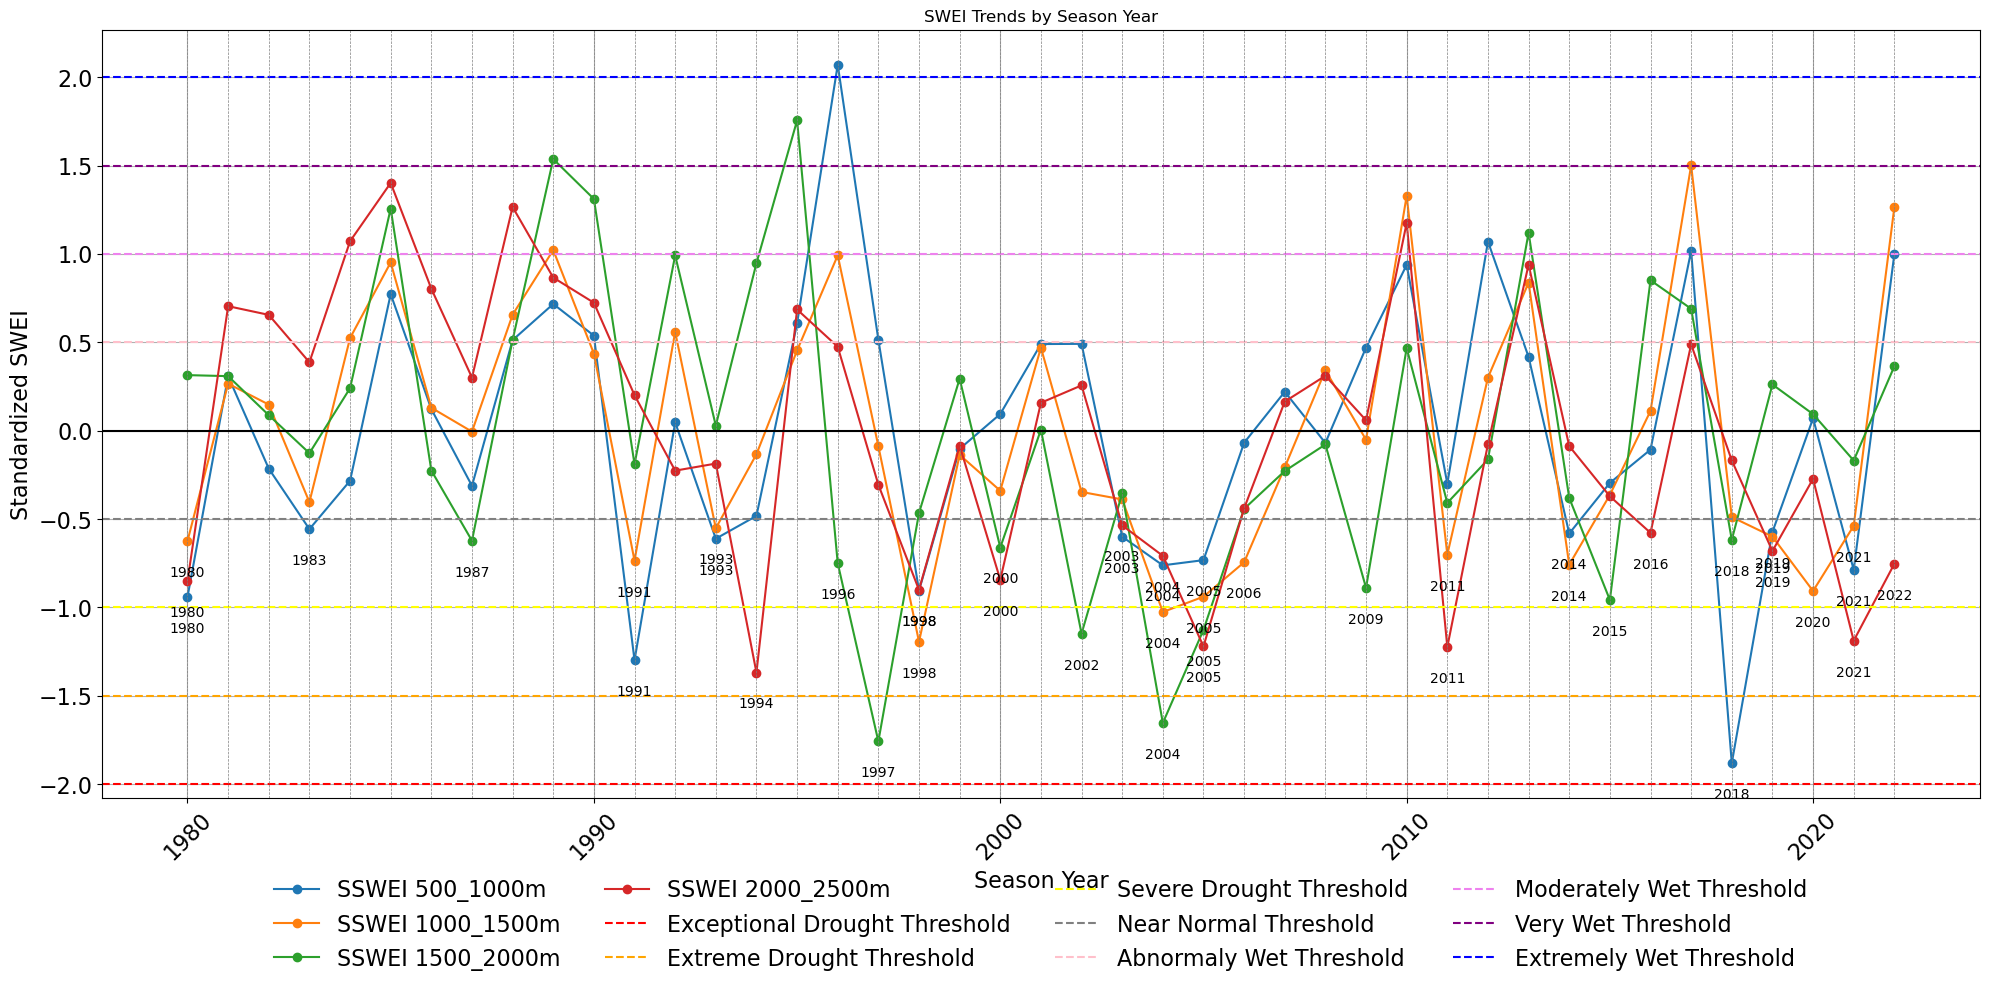

In [106]:
# Prepare data for plotting
plot_data = average_SSWEI_per_year.sort_values(by='Season_year')
plt.figure(figsize=(20, 10))
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    plt.plot(plot_data['Season_year'], plot_data[col], marker='o', label=f'SSWEI {col}')

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal Threshold')
plt.axhline(0.5, color='pink', linestyle='--', label='Abnormaly Wet Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Very Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

# trend line
#z = np.polyfit(plot_data['Season_year'], plot_data['SSWEI'], 1)
#p = np.poly1d(z)
#plt.plot(plot_data['Season_year'],p(plot_data['Season_year']),"g--", label='trend line')

# Customize the plot
plt.title('SWEI Trends by Season Year')
plt.xlabel('Season Year',fontsize=16)
plt.ylabel('Standardized SWEI',fontsize=16)
plt.xticks(rotation=45,fontsize=16)
plt.yticks(fontsize=16)
# put legend outside the plot right top 
plt.legend(['SSWEI 500_1000m', 'SSWEI 1000_1500m', 'SSWEI 1500_2000m', 'SSWEI 2000_2500m',
            'Exceptional Drought Threshold', 'Extreme Drought Threshold', 'Severe Drought Threshold',
            'Near Normal Threshold', 'Abnormaly Wet Threshold', 'Moderately Wet Threshold',
            'Very Wet Threshold', 'Extremely Wet Threshold'],
           loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=4, fontsize=16, frameon=False)
# Add gridlines for each year
for year in plot_data['Season_year'].unique():
    plt.axvline(year, color='gray', linestyle='--', linewidth=0.5)
# Add years to SSWEI < -0.5 for each elevation category
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    for i, row in plot_data.iterrows():
        if row[col] < -0.5:
            plt.text(row['Season_year'], row[col] - 0.2, str(row['Season_year']), fontsize=10, color='black', ha='center')
plt.grid()
plt.axhline(0, color='black', linewidth=1.5, linestyle='-', label='y=0')
plt.tight_layout()
plt.savefig(output_path + 'SWEI_trends.png')
plt.show()
plt.close()

# Heldmyer classification

In [129]:
# Add cumulative P values for each season year and coordinate_id
onset_to_peak['cumulative_P'] = onset_to_peak.groupby(['season_year', 'coordinate_id'])['P'].cumsum()

# keep only time, coordinate_id, SWE, P, cumulative_P columns
onset_to_peak = onset_to_peak[['season_year', 'coordinate_id', 'SWE', 'P', 'cumulative_P']] 

# Display the updated dataframe
display(onset_to_peak)

,season_year,coordinate_id,SWE,P,cumulative_P
294,1980,2,12.762125,0.664867,0.664867
295,1980,2,12.599363,0.062945,0.727812
296,1980,2,12.029484,0.000000,0.727812
297,1980,2,12.559414,0.308135,1.035947
298,1980,2,14.034721,0.848068,1.884015
...,...,...,...,...,...
291233,2016,19,389.295044,1.255833,278.087219
291234,2016,19,391.886200,0.202527,278.289734
291235,2016,19,394.390015,0.245193,278.534943
291236,2016,19,396.296539,0.003266,278.538208


In [130]:

# Initialize an empty DataFrame to store the results
onset_to_peak_mean_all = pd.DataFrame()

# Iterate through each coordinate_id
for coordinate_id in onset_to_peak['coordinate_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = onset_to_peak[onset_to_peak['coordinate_id'] == coordinate_id]
    
    # Calculate mean_SWE for each season year
    coord_data['mean_SWE'] = coord_data.groupby('season_year')['SWE'].transform('mean')
    
    # Calculate mean_SWE for each season year and select max cumulative_P for each season year
    onset_to_peak_mean = coord_data.groupby('season_year').agg(
        mean_SWE=('SWE', 'mean'),
        mean_cumulative_P=('cumulative_P', 'mean'),
        max_SWE=('SWE', 'max'),
        max_cumulative_P=('cumulative_P', 'max')
    ).reset_index()

    # calculate cumulative P anomaly
    onset_to_peak_mean['cumulative_P_anomaly'] = onset_to_peak_mean['mean_cumulative_P'] - onset_to_peak_mean['mean_cumulative_P'].mean()
    
    # Calculate mean_SWE/max_cumulative_P ratio
    onset_to_peak_mean['mean_SWE/cumulative_P'] = onset_to_peak_mean['mean_SWE'] / onset_to_peak_mean['max_cumulative_P']
    
    # Add coordinate_id to the result
    onset_to_peak_mean['coordinate_id'] = coordinate_id
    
    # Append the result to the final DataFrame
    onset_to_peak_mean_all = pd.concat([onset_to_peak_mean_all, onset_to_peak_mean])

# Display the result
display(onset_to_peak_mean_all)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\826272463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord_data['mean_SWE'] = coord_data.groupby('season_year')['SWE'].transform('mean')
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\826272463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord_data['mean_SWE'] = coord_data.groupby('season_year')['SWE'].transform('mean')
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\826272463.py:10: Settin

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P,coordinate_id
0,1980,171.529795,140.547104,294.600586,269.476685,34.043625,0.636529,2
1,1981,123.522472,94.756477,275.381927,209.734039,-11.747002,0.588948,2
2,1982,98.211099,79.827835,184.578796,146.192963,-26.675644,0.671791,2
3,1983,118.087998,90.920952,211.947189,195.835709,-15.582527,0.602995,2
4,1984,95.179610,81.743309,178.690857,159.872437,-24.760170,0.595347,2
...,...,...,...,...,...,...,...,...
32,2012,206.931667,147.850708,354.070709,258.031647,17.870941,0.801962,19
33,2013,197.705905,145.146072,447.697998,356.449707,15.166306,0.554653,19
34,2014,163.126465,135.663223,301.329865,256.753540,5.683456,0.635343,19
35,2015,103.925666,114.048340,223.613617,204.431519,-15.931427,0.508364,19


In [132]:
# Calculate the mean over coordinate_id
mean_over_coordinate_id = onset_to_peak_mean_all.groupby('season_year').mean().reset_index()

#drop coordinate_id
mean_over_coordinate_id = mean_over_coordinate_id.drop(['coordinate_id'], axis=1)

# Display the result
display(mean_over_coordinate_id)

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P
0,1980,169.830153,152.026733,283.587663,273.571136,29.879572,0.625317
1,1981,141.475820,119.866684,277.554440,239.948654,-2.280484,0.591291
2,1982,114.033175,93.282532,197.733494,168.364532,-28.864639,0.686755
3,1983,119.313631,99.426865,202.264634,193.412460,-22.720303,0.621705
4,1984,112.891217,92.937218,191.969439,176.112030,-29.209951,0.645230
5,1985,176.605270,134.737579,320.881080,290.114319,12.590398,0.603093
6,1986,138.884052,106.909164,236.692132,201.000946,-15.238007,0.692400
7,1987,101.492069,78.573936,200.063532,166.580750,-43.573235,0.619724
8,1988,130.621735,124.319130,266.174341,258.568512,2.171959,0.514675
9,1989,181.630373,161.049271,314.172343,304.236938,38.902096,0.600190


In [133]:
# Select snow drought years max_SWE< mean max_SWE
snow_drought_years = mean_over_coordinate_id[mean_over_coordinate_id['max_SWE'] < mean_over_coordinate_id['max_SWE'].mean()]

# Display the result
display(snow_drought_years)

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P
2,1982,114.033175,93.282532,197.733494,168.364532,-28.864639,0.686755
3,1983,119.313631,99.426865,202.264634,193.412460,-22.720303,0.621705
4,1984,112.891217,92.937218,191.969439,176.112030,-29.209951,0.645230
6,1986,138.884052,106.909164,236.692132,201.000946,-15.238007,0.692400
7,1987,101.492069,78.573936,200.063532,166.580750,-43.573235,0.619724
11,1991,134.181988,110.700661,219.435501,194.393234,-11.446508,0.712319
12,1992,102.676974,87.283615,219.605661,191.947083,-34.863552,0.532860
13,1993,120.914115,103.469612,238.740277,211.117020,-18.677561,0.586941
16,1996,137.176706,115.175247,236.148316,204.536270,-6.971920,0.687996
17,1997,98.067372,84.273148,189.410532,164.173737,-37.874023,0.600779


In [134]:
# normal years max_SWE> mean max_SWE
normal_years = mean_over_coordinate_id[mean_over_coordinate_id['max_SWE'] > mean_over_coordinate_id['max_SWE'].mean()]

# Display the result
display(normal_years)

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P
0,1980,169.830153,152.026733,283.587663,273.571136,29.879572,0.625317
1,1981,141.475820,119.866684,277.554440,239.948654,-2.280484,0.591291
5,1985,176.605270,134.737579,320.881080,290.114319,12.590398,0.603093
8,1988,130.621735,124.319130,266.174341,258.568512,2.171959,0.514675
9,1989,181.630373,161.049271,314.172343,304.236938,38.902096,0.600190
10,1990,222.744700,206.942841,369.720869,347.736938,84.795677,0.648136
14,1994,145.920598,123.901543,279.800537,261.181213,1.754371,0.563764
15,1995,192.939422,172.062363,339.310992,319.391876,49.915195,0.604538
19,1999,186.675596,174.409363,339.148796,318.637512,52.262199,0.586514
21,2001,144.178197,116.690811,292.426721,249.936935,-5.456355,0.574532


K mean Clustering for snow drought years

In [135]:
# standadize the cumulative P anomaly and mean_SWE/cumulative_P
snow_drought_years['cumulative_P_anomaly_z'] = (snow_drought_years['cumulative_P_anomaly'] - snow_drought_years['cumulative_P_anomaly'].mean()) / snow_drought_years['cumulative_P_anomaly'].std()
snow_drought_years['mean_SWE/cumulative_P_z'] = (snow_drought_years['mean_SWE/cumulative_P'] - snow_drought_years['mean_SWE/cumulative_P'].mean()) / snow_drought_years['mean_SWE/cumulative_P'].std()

# Display the result
display(snow_drought_years)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\3440163260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['cumulative_P_anomaly_z'] = (snow_drought_years['cumulative_P_anomaly'] - snow_drought_years['cumulative_P_anomaly'].mean()) / snow_drought_years['cumulative_P_anomaly'].std()
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\3440163260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['mean_SWE/cumulative_P_z'] = (snow_drought

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P,cumulative_P_anomaly_z,mean_SWE/cumulative_P_z
2,1982,114.033175,93.282532,197.733494,168.364532,-28.864639,0.686755,-0.444072,0.905618
3,1983,119.313631,99.426865,202.264634,193.412460,-22.720303,0.621705,-0.088135,0.003326
4,1984,112.891217,92.937218,191.969439,176.112030,-29.209951,0.645230,-0.464076,0.329629
6,1986,138.884052,106.909164,236.692132,201.000946,-15.238007,0.692400,0.345310,0.983913
7,1987,101.492069,78.573936,200.063532,166.580750,-43.573235,0.619724,-1.296132,-0.024156
11,1991,134.181988,110.700661,219.435501,194.393234,-11.446508,0.712319,0.564949,1.260205
12,1992,102.676974,87.283615,219.605661,191.947083,-34.863552,0.532860,-0.791585,-1.229013
13,1993,120.914115,103.469612,238.740277,211.117020,-18.677561,0.586941,0.146059,-0.478871
16,1996,137.176706,115.175247,236.148316,204.536270,-6.971920,0.687996,0.824159,0.922829
17,1997,98.067372,84.273148,189.410532,164.173737,-37.874023,0.600779,-0.965980,-0.286933


In [145]:
# K-means clustering
from sklearn.cluster import KMeans

# Rename the column to remove the tab character
snow_drought_years.rename(columns={'\tmean_SWE/cumulative_P': 'mean_SWE/cumulative_P'}, inplace=True)

cluster_feature = snow_drought_years[['mean_SWE/cumulative_P_z','cumulative_P_anomaly_z']]

#K = 3
kmean = KMeans(n_clusters=3,random_state=0)

#Fit the model and predict cluster labels

snow_drought_years['cluster'] = kmean.fit_predict(cluster_feature)

# Print the cluster centers and assigned clusters
print("Cluster centers:\n", kmean.cluster_centers_)
print("\nAssigned clusters:\n", snow_drought_years[['season_year', 'cluster']])

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\4148217731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years.rename(columns={'\tmean_SWE/cumulative_P': 'mean_SWE/cumulative_P'}, inplace=True)
c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variabl

Cluster centers:
 [[-0.66487374  0.96477621]
 [-0.78130307 -1.23466291]
 [ 0.78957578  0.03846595]]

Assigned clusters:
     season_year  cluster
2          1982        2
3          1983        2
4          1984        2
6          1986        2
7          1987        1
11         1991        2
12         1992        1
13         1993        0
16         1996        2
17         1997        1
18         1998        0
20         2000        1
22         2002        1
23         2003        0
24         2004        2
25         2005        2
27         2007        0
28         2008        0
29         2009        2
34         2014        0
35         2015        2


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\4148217731.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['cluster'] = kmean.fit_predict(cluster_feature)


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\893111125.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['cluster_name'] = snow_drought_years['cluster'].map(cluster_labels)


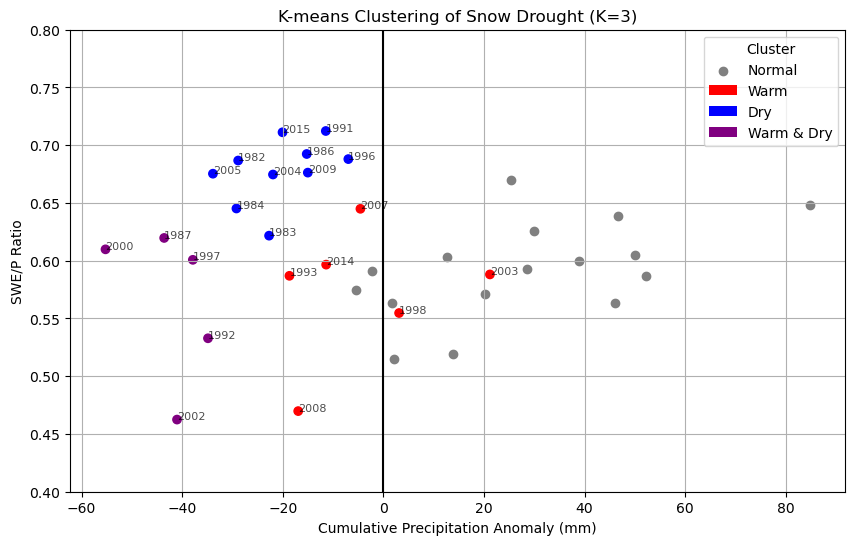

In [159]:
# Assign names to clusters based on their characteristics
cluster_labels = {
    0: 'Warm',        # Replace 0, 1, 2 with the actual cluster numbers after inspection
    1: 'Warm & Dry',
    2: 'Dry'
    
}

# Map cluster numbers to names in the DataFrame
snow_drought_years['cluster_name'] = snow_drought_years['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))

# Define colors for each cluster (adjust colors as needed)
cluster_colors = {'Warm': 'red', 'Dry': 'blue', 'Warm & Dry': 'purple'}

plt.scatter(snow_drought_years['cumulative_P_anomaly'], snow_drought_years['mean_SWE/cumulative_P'], c=snow_drought_years['cluster_name'].map(cluster_colors))
plt.scatter(normal_years['cumulative_P_anomaly'], normal_years['mean_SWE/cumulative_P'], c='grey', label='Normal')
plt.xlabel('Cumulative Precipitation Anomaly (mm)')
plt.ylabel('SWE/P Ratio')
# Add a darker gridline for y-axis at 0
plt.axvline(0, color='black', linewidth=1.5, linestyle='-')  # Darker and thicker line for y=0
#add drought year to each dot
for i, row in snow_drought_years.iterrows():
    plt.annotate(row['season_year'], (row['cumulative_P_anomaly'], row['mean_SWE/cumulative_P']), fontsize=8, color='black', alpha=0.7)
# Create a legend for named clusters
for name, color in cluster_colors.items():
    plt.bar(0, 0, color=color, label=name)
plt.legend(title='Cluster')
plt.title('K-means Clustering of Snow Drought (K=3)')
plt.ylim(0.4,0.8)
plt.grid(True)
plt.savefig(output_path + 'K-means Clustering of Seasonal Data (K=3).png')
plt.show()